In [0]:
import xml.etree.ElementTree as ET
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns                            # more plots
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize 

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# Importing sklearn metrics for error calculation

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


%matplotlib inline
# The data has been extracted from a website run by Energinet at the following link where time series data is publicly available:
# /https://www.energidataservice.dk/dataset/electricitybalance

In [0]:
# tree = ET.parse('small.xml')
tree = ET.parse('exsmall.xml')
root = tree.getroot()

In [0]:
abstimes = []
dktimes = [] 
strtimes = []   
solar = []    
abstime = 0
ctr = 0
for row in root.iter('row'):
    # print(row.attrib)    
    # print(row.text)
    dktime = 0
    for element in row.iter():
        # print(element.tag)
        if element.tag == 'HourDK':
            # print(element.text)
            strdktime = element.text
            dktime = int(strdktime[11:13])
            if dktime >= 18 or dktime <= 7:
                break    
            else:
                strtimes.append(strdktime)
                dktimes.append(dktime)
                abstimes.append(abstime)
                abstime += 1
                # print(dktimes[-1])
        elif element.tag == 'SolarPowerProd':
            # print(element.text)
            spower = float(element.text)
            solar.append(spower)
            if spower == 0:
              print("yay")
              del solar[-1]
              del strtimes[-1]
              del dktimes[-1]
              del abstimes[-1]
              abstime -= 1
            elif spower < 70.0:
              # print(dktimes[-1])
              ctr += 1

print(ctr)

yay
yay
yay
12


         0
0    138.0
1    172.0
2    207.0
3    228.0
4    276.0
..     ...
242  378.0
243  343.0
244  309.0
245  229.0
246  132.0

[247 rows x 1 columns]
1


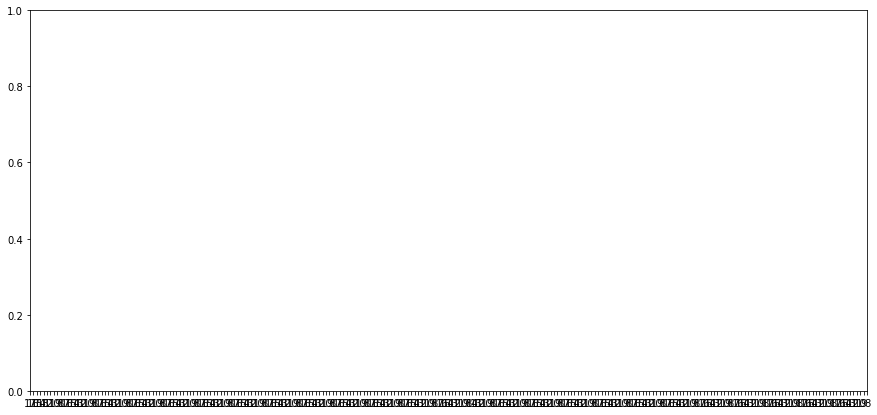

In [0]:
sdata = pd.DataFrame(solar,index=abstimes)
print(sdata)
plt.figure(figsize=(15, 7))
plt.xticks(abstimes, dktimes)
# ax = plt.gca()
# n = 5
# ax.set_xticks(ax.get_xticks()[::6])
print(1)

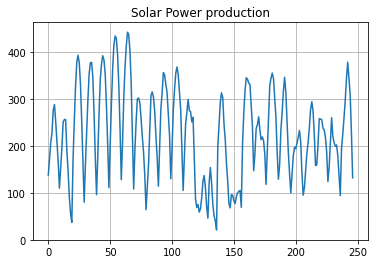

In [0]:
plt.plot(sdata)
plt.title('Solar Power production')
plt.grid(True)
plt.show()

In [0]:
print(len(solar) )

247


This is 10 days of data which is measured hourly for a duration of 10 hours everday from 7 am to 5 pm. We try to apply the paper's methodology for the hourly datapoints to predict solar power generation for the next hour given the data for the previous hours.


In [0]:
# smoothing using moving averages
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

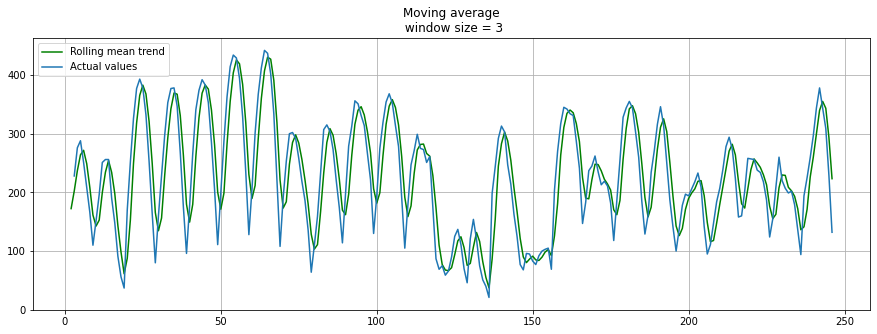

In [0]:
# Moving Average with interval = 3
plotMovingAverage(sdata, 3) 


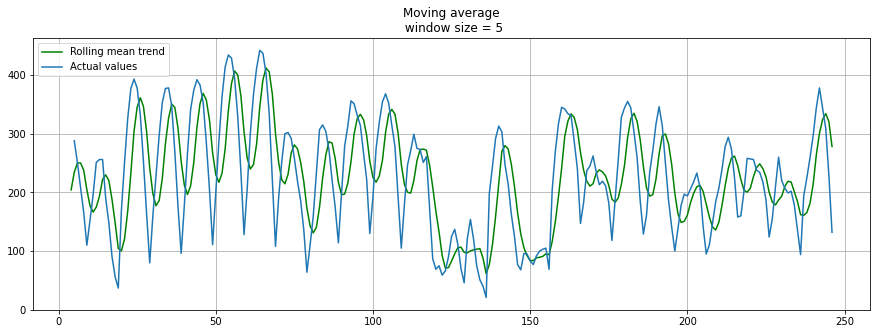

In [0]:
# Moving Average with interval = 5
plotMovingAverage(sdata, 5) 


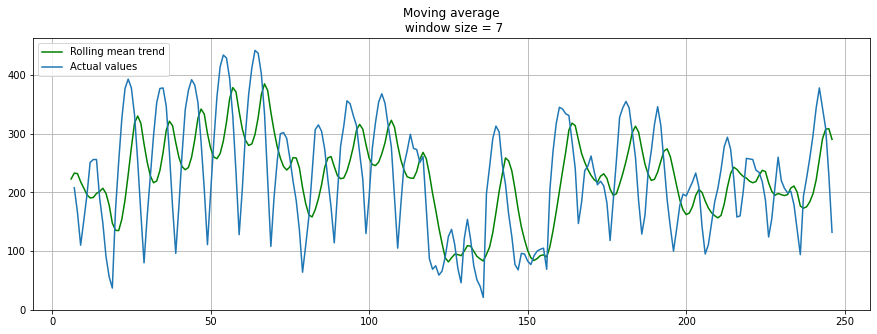

In [0]:
# Moving Average with interval = 7
plotMovingAverage(sdata, 7) 


In [0]:
# get Mean Absolute Error (MAE) for MA = 3
window = 3
rolling_mean = sdata.rolling(window=window).mean()
err = mean_absolute_error(sdata[window:], rolling_mean[window:]) 
print(err)

37.84016393442623


In [0]:
# get Mean Absolute Error (MAE) for MA = 5
window = 5
rolling_mean = sdata.rolling(window=window).mean()
err = mean_absolute_error(sdata[window:], rolling_mean[window:]) 
print(err)

61.150413223140504


In [0]:
# get Mean Absolute Error (MAE) for MA = 7
window = 7
rolling_mean = sdata.rolling(window=window).mean()
err = mean_absolute_error(sdata[window:], rolling_mean[window:]) 
print(err)

70.96428571428572


In [0]:
# get Root Mean Square Error(RMSE)  for MA = 3
window = 3
rolling_mean = sdata.rolling(window=window).mean()
rms = sqrt(mean_squared_error(sdata[window:], rolling_mean[window:]))
print(rms)

46.0219566272804


In [0]:
# get Root Mean Square Error(RMSE)  for MA = 5
window = 5
rolling_mean = sdata.rolling(window=window).mean()
rms = sqrt(mean_squared_error(sdata[window:], rolling_mean[window:]))
print(rms)

73.86068189895427


In [0]:
# get Root Mean Square Error(RMSE)  for MA = 7
window = 7
rolling_mean = sdata.rolling(window=window).mean()
rms = sqrt(mean_squared_error(sdata[window:], rolling_mean[window:]))
print(rms)


86.55313436281328


In [0]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    valid = 0.0
    sums = 0.0
    for y,x in zip(y_true,y_pred):
      if y == 0:
        print("yes")
      else:
        sums += np.abs((y - x) / (y))
        valid += 1.0
    print(sums)
    print(valid)
    nsums = np.mean(sums)
    print(nsums)
    return (sums/valid) * 100

def mean_absolute_percentage_error_short(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
# get Mean Absolute Percentage Error (MAPE) for MA = 7
window = 7
rolling_mean = sdata.rolling(window=window).mean()
mape = mean_absolute_percentage_error_short(sdata[window:], rolling_mean[window:])
print(mape)

42.698186917148305


In [0]:
# get Mean Absolute Percentage Error (MAPE) for MA = 3
window = 3
rolling_mean = sdata.rolling(window=window).mean()
mape = mean_absolute_percentage_error_short(sdata[window:], rolling_mean[window:])
print(mape)

21.60114635203506


In [0]:
# get Mean Absolute Percentage Error (MAPE) for MA = 5
window = 5
rolling_mean = sdata.rolling(window=window).mean()
mape = mean_absolute_percentage_error_short(sdata[window:], rolling_mean[window:])
print(mape)

35.63883530815693


In [0]:
print(len(sdata))

247
